In [5]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.distributions import Normal
from torch.utils.data import Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.distributions import Categorical, Normal, StudentT
import torch.distributions as dist
from torch.optim import SGD
from collections import deque
from tqdm import trange
import tqdm
import copy



In [6]:
# MNIST dataset
transform = transforms.Compose([torchvision.transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [5]:
# subsample from trainset
n_subsamples_train = 5000 # size of subset
sub_train_idx = random.sample(range(60000),n_subsamples_train) # 60'000 is train size in MNSIT
sub_train_set = Subset(train_set, sub_train_idx)

# subsample from testset
n_subsamples_test = 1000  # size of subset
sub_test_idx = random.sample(range(10000), n_subsamples_test) # 10'000 is test size in MNIST
sub_test_set = Subset(test_set, sub_test_idx)

# load
#sub_train_dataloader = DataLoader(sub_train_set, batch_size=64, shuffle=True)
sub_test_dataloader = DataLoader(sub_test_set, batch_size=64, shuffle=False)


9


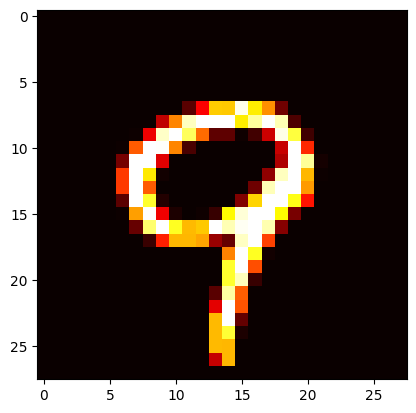

9


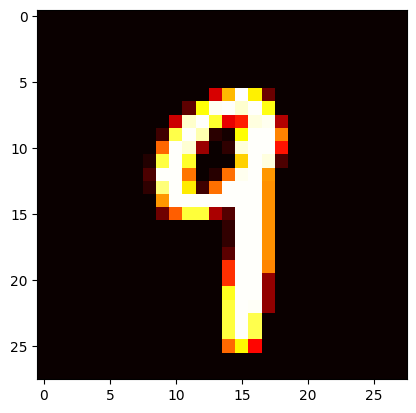

In [6]:
# Quick Check 
feature_test = sub_test_set[999][0]
label_test = sub_test_set[999][1]
print(label_test)
plt.imshow(feature_test.squeeze(), cmap='hot')
plt.show()


feature_train = sub_train_set[1999][0]
label_train = sub_train_set[1999][1]
print(label_train)
plt.imshow(feature_train.squeeze(), cmap='hot')
plt.show()


    Model Part Krause

In [7]:
# Create Class for Priors

class Prior:
    def __init__(self):
        pass
    def sample(self,n):
        pass
    def log_likelihood(self,values):
        pass

In [8]:
# Create Gaussian Prior
# Change: to a subclass of Prior

class IsotropicGaussian(Prior):
    def __init__(self, mean=0, std=1):
        super(IsotropicGaussian,self).__init__()
        self.mean = mean
        self.std = std

    def sample(self, n):
        return np.random.normal(self.mean, self.std, size=n)

    def log_likelihood(self, weights):
        return Normal(self.mean, self.std).log_prob(torch.tensor(weights)).sum()


In [18]:
# Fully Connected Neural Network 

class FullyConnectedNN(nn.Module):
    def __init__(self, in_features = 28*28, out_features = 10, hidden_units = 100, hidden_layers = 3):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(in_features, hidden_units))
        for i in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_units, hidden_units))
        self.output_layer = nn.Linear(hidden_units, out_features)

    def forward(self, x):
        x = x.reshape(-1,28*28)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        class_probs = self.output_layer(x)
        return class_probs
        

In [10]:
# Convolutional Neural Network 

class ConvolutionalNN(nn.Module):
    def __init__(self, in_features = 28*28, out_features = 10):

    # define two convolutional layers with 64 channels
        self.conv1 = nn.Conv2d(in_channels=2000, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # define two max-pooling layers
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # define a fully-connected layer
        self.fc = nn.Linear(in_features=3*3*64, out_features=out_features)
        
        # define the ReLU nonlinearity
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.activ(self.maxpool1(self.activ(self.conv1(x))))
        x = self.activ(self.maxpool2(self.activ(self.conv2(x))))
        x = x.view(x.size(0), -1)
        class_probs = self.fc(x)
        return class_probs

# DEBUG THIS 
        

In [12]:
# Framework

class Framework(object):
    def __init__(self, training_set, *args, **kwargs):
        """
        Basic Framework for your bayesian neural network.
        SGLD will be based on this.
        """
        self.train_set = training_set
        self.print_interval = 64 # number of batches until updated metrics are displayed during training

    def train(self):
        raise NotImplementedError()

    def predict(self, data_loader: torch.utils.data.DataLoader) -> np.ndarray:
        """
        Predict the class probabilities using your trained model.
        This method should return an (num_samples, 10) NumPy float array
        such that the second dimension sums up to 1 for each row.

        :param data_loader: Data loader yielding the samples to predict on
        :return: (num_samples, 10) NumPy float array where the second dimension sums up to 1 for each row
        """
        probability_batches = []
        
        for batch_x, _ in tqdm.tqdm(data_loader):
            current_probabilities = self.predict_probabilities(batch_x).detach().numpy()
            probability_batches.append(current_probabilities)

        output = np.concatenate(probability_batches, axis=0)
        assert isinstance(output, np.ndarray)
        assert output.ndim == 2 and output.shape[1] == 10
        assert np.allclose(np.sum(output, axis=1), 1.0)
        return output

    def predict_probabilities(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

In [13]:
import torch
import math
import numpy as np
from collections import OrderedDict
from typing import Sequence, Optional, Callable, Tuple, Dict, Union
import typing


def dot(a, b):
    "return (a*b).sum().item()"
    return (a.view(-1) @ b.view(-1)).item()

## Fortuin SGLD code


class SGLD(torch.optim.Optimizer):
    """SGLD with momentum, preconditioning and diagnostics from Wenzel et al. 2020.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        num_data (int): the number of data points in this learning task
        momentum (float): momentum factor (default: 0)
        temperature (float): Temperature for tempering the posterior.
                             temperature=0 corresponds to SGD with momentum.
        rmsprop_alpha: decay for the moving average of the squared gradients
        rmsprop_eps: the regularizer parameter for the RMSProp update
        raise_on_no_grad (bool): whether to complain if a parameter does not
                                 have a gradient
        raise_on_nan: whether to complain if a gradient is not all finite.
    """
    def __init__(self, params: Sequence[Union[torch.nn.Parameter, Dict]], lr: float,
                 num_data: int, momentum: float=0, temperature: float=1.,
                 rmsprop_alpha: float=0.99, rmsprop_eps: float=1e-8,  # Wenzel et al. use 1e-7
                 raise_on_no_grad: bool=True, raise_on_nan: bool=False):
        assert lr >= 0 and num_data >= 0 and momentum >= 0 and temperature >= 0
        defaults = dict(lr=lr, num_data=num_data, momentum=momentum,
                        rmsprop_alpha=rmsprop_alpha, rmsprop_eps=rmsprop_eps,
                        temperature=temperature)
        super(SGLD, self).__init__(params, defaults)
        self.raise_on_no_grad = raise_on_no_grad
        self.raise_on_nan = raise_on_nan
        # OK to call this one, but not `sample_momentum`, because
        # `update_preconditioner` uses no random numbers.
        self.update_preconditioner()
        self._step_count = 0  # keep the `torch.optim.scheduler` happy

    def _preconditioner_default(self, state, p) -> float:
        try:
            return state['preconditioner']
        except KeyError:
            v = state['preconditioner'] = 1.
            return v

    def delta_energy(self, a, b) -> float:
        return math.inf

    @torch.no_grad()
    def sample_momentum(self, keep=0.0):
        "Sample the momenta for all the parameters"
        assert 0 <= keep and keep <= 1.
        if keep == 1.:
            return
        for group in self.param_groups:
            std = math.sqrt(group['temperature']*(1-keep))
            for p in group['params']:
                if keep == 0.0:
                    self.state[p]['momentum_buffer'] = torch.randn_like(p).mul_(std)
                else:
                    self.state[p]['momentum_buffer'].mul_(math.sqrt(keep)).add_(torch.randn_like(p), alpha=std)

    @torch.no_grad()
    def step(self, closure: Optional[Callable[..., torch.Tensor]]=None,
             calc_metrics=True, save_state=False):
        assert save_state is False
        return self._step_internal(self._update_group_fn, self._step_fn,
                                   closure, calc_metrics=calc_metrics)
    initial_step = step

    @torch.no_grad()
    def final_step(self, closure: Optional[Callable[..., torch.Tensor]]=None,
                   calc_metrics=True, save_state=False):
        assert save_state is False
        return self._step_internal(self._update_group_fn, self._step_fn,
                                   closure, calc_metrics=calc_metrics,
                                   is_final=True)


    def _step_internal(self, update_group_fn, step_fn, closure, **step_fn_kwargs):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        try:
            for group in self.param_groups:
                update_group_fn(group)
                for p in group['params']:
                    if p.grad is None:
                        if self.raise_on_no_grad:
                            raise RuntimeError(
                                f"No gradient for parameter with shape {p.shape}")
                        continue
                    if self.raise_on_nan and not torch.isfinite(p.grad).all():
                        raise ValueError(
                            f"Gradient of shape {p.shape} is not finite: {p.grad}")
                    step_fn(group, p, self.state[p], **step_fn_kwargs)

        except KeyError as e:
            if e.args[0] == "momentum_buffer":
                raise RuntimeError("No 'momentum_buffer' stored in state. "
                                   "Perhaps you forgot to call `sample_momentum`?")
            raise e
        return loss

    def _update_group_fn(self, g):
        g['hn'] = math.sqrt(g['lr'] * g['num_data'])
        g['h'] = math.sqrt(g['lr'] / g['num_data'])
        g['noise_std'] = math.sqrt(2*(1 - g['momentum']) * g['temperature'])

    def _step_fn(self, group, p, state, calc_metrics=True, is_final=False):
        """if is_final, do not change parameters or momentum"""
        M_rsqrt = self._preconditioner_default(state, p)
        d = p.numel()

        # Update the momentum with the gradient
        if group['momentum'] > 0:
            momentum = state['momentum_buffer']
            if calc_metrics:
                # NOTE: the momentum is from the previous time step
                state['est_temperature'] = dot(momentum, momentum) / d
            if not is_final:
                momentum.mul_(group['momentum']).add_(p.grad, alpha=-group['hn']*M_rsqrt)
        else:
            if not is_final:
                momentum = p.grad.detach().mul(-group['hn']*M_rsqrt)
            if calc_metrics:
                # TODO: make the momentum be from the previous time step
                state['est_temperature'] = dot(momentum, momentum) / d

        if not is_final:
            # Add noise to momentum
            if group['temperature'] > 0:
                momentum.add_(torch.randn_like(momentum), alpha=group['noise_std'])

        if calc_metrics:
            # NOTE: p and p.grad are from the same time step
            state['est_config_temp'] = dot(p, p.grad) * (group['num_data']/d)

        if not is_final:
            # Take the gradient step
            p.add_(momentum, alpha=group['h']*M_rsqrt)

            # RMSProp moving average
            alpha = group['rmsprop_alpha']
            state['square_avg'].mul_(alpha).addcmul_(p.grad, p.grad, value=1 - alpha)

    @torch.no_grad()
    def update_preconditioner(self):
        """Updates the preconditioner for each parameter `state['preconditioner']` using
        the estimated `state['square_avg']`.
        """
        precond = OrderedDict()
        min_s = math.inf

        for group in self.param_groups:
            eps = group['rmsprop_eps']
            for p in group['params']:
                state = self.state[p]
                try:
                    square_avg = state['square_avg']
                except KeyError:
                    square_avg = state['square_avg'] = torch.ones_like(p)

                precond[p] = square_avg.mean().item() + eps
                min_s = min(min_s, precond[p])

        for p, new_M in precond.items():
            # ^(1/2) to form the preconditioner,
            # ^(-1/2) because we want the preconditioner's inverse square root.
            self.state[p]['preconditioner'] = (new_M / min_s)**(-1/4)

In [14]:
class SGLDTrainer(Framework):
    def __init__(self, dataset_train, network, prior, *args, **kwargs):
        super().__init__(dataset_train, *args, **kwargs)

        # Hyperparameters and general parameters
        self.batch_size = 128
        self.learning_rate = 1e-3
        self.num_epochs = 10
        self.burn_in = 2
        self.sample_interval = 2
        self.max_size = 100
        
        self.sample_size = dataset_train.__len__()
        self.data_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

        # Set Prior
        self.prior = prior

        # Initialize the SGLD network
        self.network = network

        # SGLD optimizer is provided
        self.optimizer = SGLD(self.network.parameters(), lr=self.learning_rate, num_data=self.sample_size)

        # Learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.9)

        # Deque to store model samples
        self.SGLDSequence = deque()

    def train(self):
        num_iter = 0
        print('Training model')

        self.network.train()
        progress_bar = trange(self.num_epochs)

        for _ in progress_bar:
            num_iter += 1

            N = self.sample_size

            for batch_idx, (batch_x, batch_y) in enumerate(self.data_loader):
                self.network.zero_grad()
                n = len(batch_x)

                # Perform forward pass
                current_logits = self.network(batch_x)

                # Calculate log_likelihood of weights for a given prior

                parameters = self.network.state_dict()     # extract weights from network
                param_values = list(parameters.values())    # list weights
                param_flat = np.concatenate([v.flatten() for v in param_values])    # flattern
                log_likelihood = self.prior.log_likelihood(param_flat)              # calculate log_lik

                # Calculate the loss
                loss = F.nll_loss(F.log_softmax(current_logits, dim=1), batch_y, reduction = "sum") - log_likelihood*n/N

                # Backpropagate to get the gradients
                loss.backward()

                self.optimizer.step()

                if batch_idx % self.print_interval == 0:
                    current_logits = self.network(batch_x)
                    current_accuracy = (current_logits.argmax(axis=1) == batch_y).float().mean()
                    progress_bar.set_postfix(loss=loss.item(), acc=current_accuracy.item(),
                    nll_loss= F.nll_loss(F.log_softmax(current_logits, dim=1), batch_y, reduction = "sum").item(),
                    log_lik_prior = - log_likelihood.item()*n/N)

            # Update the learning rate
            self.scheduler.step()
            
            # Save the model samples if past the burn-in epochs and reached a regular sampling interval
            if num_iter > self.burn_in and num_iter % self.sample_interval == 0:
                self.SGLDSequence.append(copy.deepcopy(self.network))
                # self.network.state_dict()

            # If the deque exceeds the maximum size, delete the oldest model
            if len(self.SGLDSequence) > self.max_size:
                self.SGLDSequence.popleft()

    def predict_probabilities(self, x: torch.Tensor) -> torch.Tensor:
        #assert x.shape[1] == 28 ** 2
        self.network.eval()

        # Obtain the prediction from each network in SGLDSequence and combine the predictions
        estimated_probability = torch.zeros((len(x), 10))
        for model in self.SGLDSequence:


            self.network.load_state_dict(model.state_dict())
            logits = self.network(x).detach()
            estimated_probability += F.softmax(logits, dim=1)
        
        # Normalize the combined predictions
        estimated_probability /= len(self.SGLDSequence)

        assert estimated_probability.shape == (x.shape[0], 10)  
        return estimated_probability



# Normal prior

In [32]:
lol = SGLDTrainer(train_set,network= FullyConnectedNN(),prior= IsotropicGaussian(mean = 0, std = 1))
lol.train()

Training model


100%|██████████| 10/10 [02:35<00:00, 15.53s/it, acc=0.984, log_lik_prior=97.9, loss=101, nll_loss=2.21]


In [33]:
# test set
x_test = sub_test_set.dataset.data.float()
y_test = sub_test_set.dataset.targets

# predicted probabilities
class_probs = lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.9683


In [34]:
# Calibration
import torchmetrics
from torchmetrics.functional import calibration_error

calib_err = calibration_error(class_probs, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Calibration Error: 0.0205


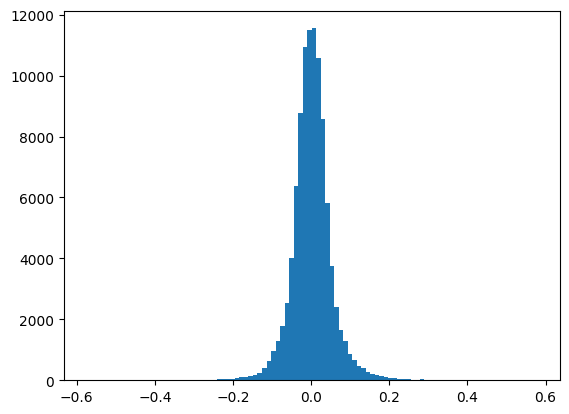

In [35]:
# get weights
parameters = lol.network.state_dict()
param_values = list(parameters.values())
param_flat = np.concatenate([v.flatten() for v in param_values])

# plot weights
plt.hist(param_flat, bins=100)
plt.show()


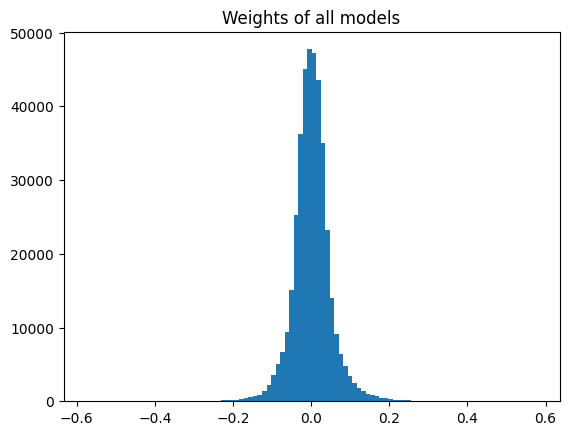

In [37]:
# get weights from all models
param_flat_all = []
for model in lol.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Gaussian prior")
plt.show()


# Student-t prior

In [38]:
class StudentTPrior(Prior):
    """
    Student-T Prior
    """
    def __init__(self, df=10, loc=0, scale=1, Temperature: float= 1.0):
        super().__init__()
        self.df = df
        self.loc = loc
        self.scale = scale
        self.Temperature = Temperature

    def log_likelihood(self, values) -> torch.Tensor:
        return StudentT(self.df, self.loc, self.scale).log_prob(torch.tensor(values)).sum() / self.Temperature

    def sample(self,n):
        return StudentT(self.df, self.loc, self.scale).sample((n,))  # sample from student-T

In [39]:
student_lol = SGLDTrainer(train_set,network = FullyConnectedNN(), prior=StudentTPrior())
student_lol.train()

Training model


100%|██████████| 10/10 [02:25<00:00, 14.54s/it, acc=0.984, log_lik_prior=101, loss=108, nll_loss=4.74]


In [40]:
# predicted probabilities
class_probs_t = student_lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs_t.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.9675


In [41]:
calib_err = calibration_error(class_probs_t, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Calibration Error: 0.0205


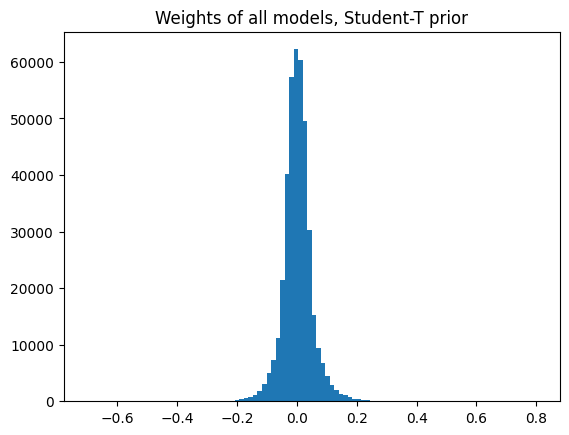

In [45]:
# get weights from all models
param_flat_all = []
for model in student_lol.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Student-T prior")
plt.show()

# Laplace prior

In [46]:
class LaplacePrior(Prior):
    """
    Laplace Prior
    """
    def __init__(self, mu: torch.Tensor, rho: torch.Tensor, Temperature: float=1.0):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.sig = torch.log(1 + torch.exp(rho))   # transform rho
        self.Temperature = Temperature

    def log_likelihood(self, values: torch.Tensor) -> torch.Tensor:
        return dist.Laplace(self.mu, self.sig).log_prob(torch.tensor(values)).sum() / self.Temperature

    def sample(self) -> torch.Tensor:
        return dist.Laplace(self.mu, self.sig).sample(torch.Tensor(1).shape).view(self.mu.shape)  # sample from laplace

In [47]:
Laplace_lol = SGLDTrainer(train_set,network = FullyConnectedNN(), prior=LaplacePrior(mu=torch.tensor(0.), rho=torch.tensor(1.)))
Laplace_lol.train()

Training model


100%|██████████| 10/10 [02:27<00:00, 14.77s/it, acc=1, log_lik_prior=106, loss=107, nll_loss=0.795]  


In [48]:
# predicted probabilities
class_probs_t = Laplace_lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs_t.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

calib_err = calibration_error(class_probs_t, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Test Accuracy: 0.9640
Calibration Error: 0.0222


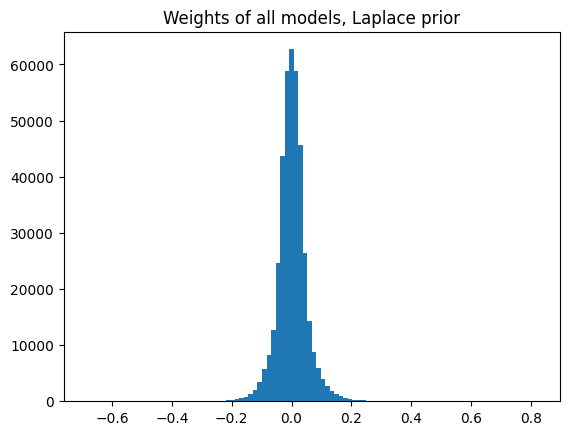

In [49]:
# get weights from all models
param_flat_all = []
for model in Laplace_lol.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Laplace prior")
plt.show()

# Inverse Gamma prior

In [50]:
from scipy.special import gamma

class InverseGamma(Prior):
    """ Inverse Gamma distribution """
    def __init__(self, shape: torch.Tensor, rate: torch.Tensor, Temperature: float = 1.0):
        """
        shape: shape parameters of the distribution
        rate: rate parameters of the distribution
        """
        self.shape = shape
        self.rate = rate
        self.Temperature = Temperature

    def log_likelihood(self, values: torch.Tensor) -> torch.Tensor:
        """
        Computes the value of the predictive log likelihood at the target value
        Args:
            target: Torch tensor of floats, point(s) to evaluate the logprob
        Returns:
            loglike: float, the log likelihood
        """
        x = (self.rate**self.shape) / gamma(self.shape)
        y = torch.tensor(values)**(-self.shape - 1)
        z = torch.exp(-self.rate / values)
        return torch.log(x * y * z)

    def sample(self) -> torch.Tensor:
        # sample from gamma and return 1/x
        x = dist.Gamma(self.shape, self.rate).sample()
        return 1/x

In [51]:
IG_lol = SGLDTrainer(sub_train_set,network = FullyConnectedNN(), prior=InverseGamma(shape=torch.tensor(0.5), rate=torch.tensor(0.5)))
IG_lol.train()

Training model


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
# predicted probabilities
class_probs_t = IG_lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs_t.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

calib_err = calibration_error(class_probs_t, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

In [ ]:
# get weights from all models
param_flat_all = []
for model in IG_lol.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Inverse Gamma prior")
plt.show()

# GMM prior

In [52]:
class GaussianMixture(Prior):
    """
    Mixture of 2 gaussians with same mean but different variances
    """
    def __init__(self,  mu: torch.Tensor, rho1: torch.Tensor, rho2: torch.Tensor, mixing_coef: float=0.7 ,Temperature: float = 1.0):
        super().__init__()
        self.mu = mu
        self.rho1 = rho1
        self.rho2 = rho2
        self.sig1 = torch.log(1 + torch.exp(rho1))  # transform rho
        self.sig2 = torch.log(1 + torch.exp(rho2))  # transform rho
        self.mixing_coef = mixing_coef
        self.Temperature = Temperature

    def log_likelihood(self, values: torch.Tensor) -> torch.Tensor:
        p1 = dist.Normal(self.mu, self.sig1).log_prob(values)
        p2 = dist.Normal(self.mu, self.sig2).log_prob(values)
        log_lik = (p1 * self.mixing_coef + p2 * (1-self.mixing_coef)).sum() / self.Temperature
        return log_lik

    def sample(self) -> torch.Tensor:
        eps = torch.randn_like(self.mu)
        sample1 = self.mu + self.sig1 * eps
        eps = torch.randn_like(self.mu)
        sample2 = self.mu + self.sig2 * eps
        return sample1 * self.mixing_coef + sample2 * (1-self.mixing_coef)

In [20]:
GMM_lol = SGLDTrainer(train_set,network = FullyConnectedNN(), prior=LaplacePrior(mu=torch.tensor(0.), rho=torch.tensor(1.)))
GMM_lol.train()

NameError: name 'LaplacePrior' is not defined

In [54]:
# predicted probabilities
class_probs_t = GMM_lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs_t.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

calib_err = calibration_error(class_probs_t, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Test Accuracy: 0.9662
Calibration Error: 0.0237


In [59]:
# get weights from all models
param_flat_all = []
for model in GMM_lol.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())
    plt.hist(param_flat, bins=100)
    plt.show()

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Gaussian Mixture prior")
plt.show()

# Pretrained Prior


In [67]:
from data import *
from models import *

In [68]:
# Load FashionMNIST dataset for pretrain task
transform = tr.Compose([tr.ToTensor()])

dataset = Data("FashionMNIST", augmentations = None)
train_data, test_data = dataset.get_data()

# Print some information about the dataset
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Train data size:  60000
Test data size:  10000


In [69]:
SGLD_model_normal = SGLDTrainer(train_data, network = FullyConnectedNN(), prior=IsotropicGaussian(mean=torch.tensor(0.), std=torch.tensor(1.)))
SGLD_model_normal.train()

Training model


100%|██████████| 10/10 [00:55<00:00,  5.54s/it, acc=0.891, log_lik_prior=97.9, loss=119, nll_loss=17.5]


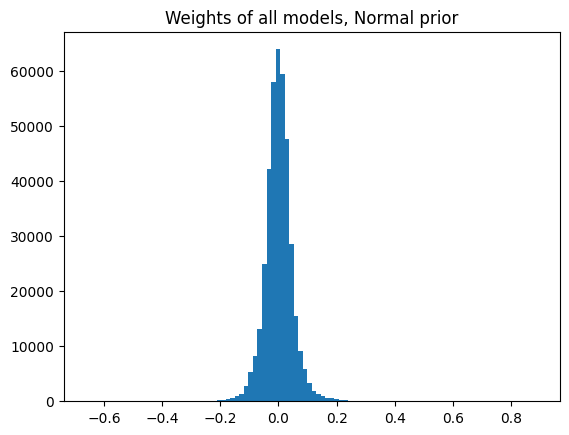

In [70]:
param_flat_all = []
for model in SGLD_model_normal.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Normal prior")
plt.show()

In [71]:
print("Mean of weights: ", np.mean(params))
print("Std of weights: ", np.std(params))

Mean of weights:  0.0004731368
Std of weights:  0.048908655


In [72]:
weight_mat = np.stack(param_flat_all).transpose()
cov = np.var(weight_mat, axis=1)
means = np.mean(weight_mat, axis=1)
print("Covariance matrix: ", cov.shape)
print("Means: ", means.shape)

Covariance matrix:  (99710,)
Means:  (99710,)


In [73]:
class DiagonalGaussian(Prior):
    """
    Multivariate diagonal Gaussian distribution,
    i.e., assumes all elements to be independent Gaussians
    but with different means and standard deviations.
    This parameterizes the standard deviation via a parameter rho as
    sigma = softplus(rho).
    """
    def __init__(self, mu: torch.Tensor, var: torch.Tensor, Temperature: float = 1.0):
        super(DiagonalGaussian, self).__init__()  
        self.mu = mu
        self.var = var
        self.covar = torch.diag(var)
        self.Temperature = Temperature

    def log_likelihood(self, values: torch.Tensor) -> torch.Tensor:
        # TODO: Implement this
        return dist.Normal(self.mu, self.var).log_prob(values).sum() / self.Temperature

    def sample(self) -> torch.Tensor:
        # TODO: Implement this
        return dist.Normal(self.mu, self.var).sample()

Fit of MNIST

In [74]:
# Load FashionMNIST dataset for pretrain task
transform = tr.Compose([tr.ToTensor()])

dataset = Data("MNIST", augmentations = None)
train_data, test_data = dataset.get_data()

# Print some information about the dataset
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Train data size:  60000
Test data size:  10000


In [75]:
new_model = SGLDTrainer(train_data, network = FullyConnectedNN(), 
    prior=IsotropicGaussian(mean=np.mean(params), std = np.std(params)))

new_model.train()

Training model


100%|██████████| 10/10 [01:00<00:00,  6.03s/it, acc=1, log_lik_prior=-162, loss=-159, nll_loss=2.12]   


In [79]:
# predict class probabilities for the test data
x_test = test_data[:][0].clone().detach()
y_test = test_data[:][1].clone().detach()

# predicted probabilities
class_probs_t = new_model.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs_t.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

from torchmetrics.functional import calibration_error

calib_err = calibration_error(class_probs_t, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Test Accuracy: 0.9731
Calibration Error: 0.0084


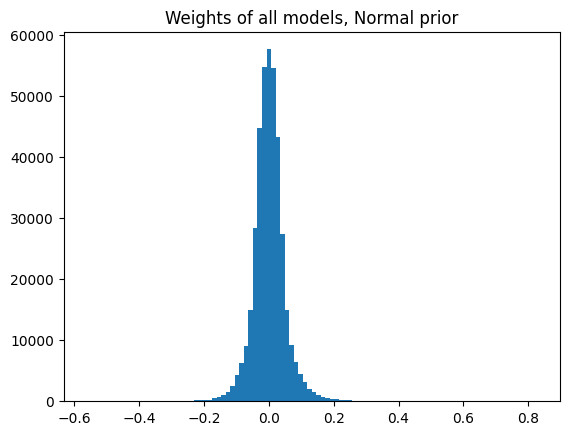

In [80]:
param_flat_all = []
for model in new_model.SGLDSequence:
    parameters = model.state_dict()
    param_values = list(parameters.values())
    param_flat = torch.cat([v.flatten() for v in param_values])
    param_flat_all.append(param_flat.flatten())

# put all weights in one array
params = np.concatenate(param_flat_all)

# plot weights
plt.hist(params, bins=100)
plt.title("Weights of all models, Normal prior")
plt.show()

Use diagonal Covariance matrix

In [64]:
new_model = SGLDTrainer(train_data, network = FullyConnectedNN(), 
    prior=(mu=torch.tensor(means), var=torch.tensor(cov), Temperature=1.0))

new_model.train()

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 39768336400 bytes.